In [2]:
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 15 14:49:58 2022

@author: Sidi Wu and Cédric Beaulac

Functional autoencoder implementation
"""

# Import modules
import sys
import torch
import torch.nn.init as init
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import save_image
import pandas as pd
import numpy as np
from numpy import *
import seaborn as sns
import matplotlib
#matplotlib.use('TkAgg')
from matplotlib import pyplot as plt
# import skfda as fda
# from skfda import representation as representation
# from skfda.exploratory.visualization import FPCAPlot
# # from skfda.exploratory.visualization import FPCAPlot
# # from skfda.preprocessing.dim_reduction import FPCA
# # from skfda.representation.basis import BSpline, Fourier, Monomial
import scipy
from scipy.interpolate import BSpline
import os
import ignite
import sklearn
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans
import random
from random import seed
from scipy import stats
import statistics
from statistics import stdev
import skfda


In [3]:

# os.chdir('C:/FAE')
os.chdir('C:/Users/Utilisateur/Documents/Master_SSD/STAGE_RECHERCHE/FDA_python')
if not os.getcwd() in sys.path:
    sys.path.append(os.getcwd())
import DataGenerator
from DataGenerator import *
import DataGenerator_NN
from DataGenerator_NN import *
import Functions
from Functions import *


In [4]:
help(DataGenerator)

Help on function DataGenerator in module DataGenerator:

DataGenerator(nc=250, tpts=array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]), classes=4, noise=2)
    # nc: number of data points per *class*, classes: number of classes/cluster, noise:std of the normal noise



In [5]:
##Importation des données sous forme FDA

ElNino_OISST_region_1and2=skfda.datasets.fetch_cran("ElNino_OISST_region_1and2","rainbow")
ElNino_OISST_region_3=skfda.datasets.fetch_cran("ElNino_OISST_region_3","rainbow")
ElNino_OISST_region_4=skfda.datasets.fetch_cran("ElNino_OISST_region_4","rainbow")
ElNino_OISST_region_3and4=skfda.datasets.fetch_cran("ElNino_OISST_region_3and4","rainbow")


c:\Users\Utilisateur\anaconda3\lib\site-packages\rdata\conversion\_conversion.py:843: UserWarning: Missing constructor for R class "sfts". The constructor for class "fts" will be used instead.
  warnings.warn(
c:\Users\Utilisateur\anaconda3\lib\site-packages\rdata\conversion\_conversion.py:843: UserWarning: Missing constructor for R class "fts". The constructor for class "fds" will be used instead.
  warnings.warn(
c:\Users\Utilisateur\anaconda3\lib\site-packages\rdata\conversion\_conversion.py:843: UserWarning: Missing constructor for R class "fds". The underlying R object is returned instead.
  warnings.warn(
c:\Users\Utilisateur\anaconda3\lib\site-packages\rdata\conversion\_conversion.py:843: UserWarning: Missing constructor for R class "sfts". The constructor for class "fts" will be used instead.
  warnings.warn(
c:\Users\Utilisateur\anaconda3\lib\site-packages\rdata\conversion\_conversion.py:843: UserWarning: Missing constructor for R class "fts". The constructor for class "fds" w

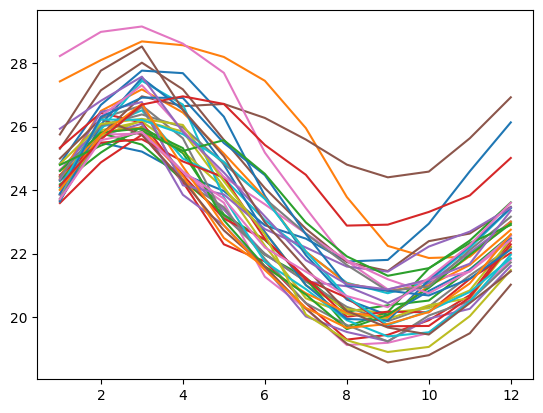

In [6]:
ElNino_OISST_region_1and2_y=ElNino_OISST_region_1and2['ElNino_OISST_region_1and2']['y'].to_numpy()
ElNino_OISST_region_1and2_x=ElNino_OISST_region_1and2['ElNino_OISST_region_1and2']['x']
plt.plot(ElNino_OISST_region_1and2_x,ElNino_OISST_region_1and2_y)
plt.show(
)

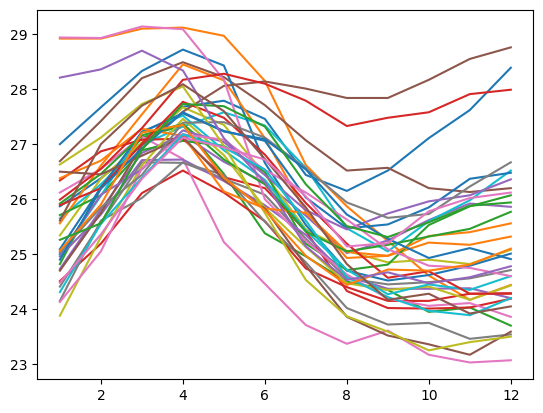

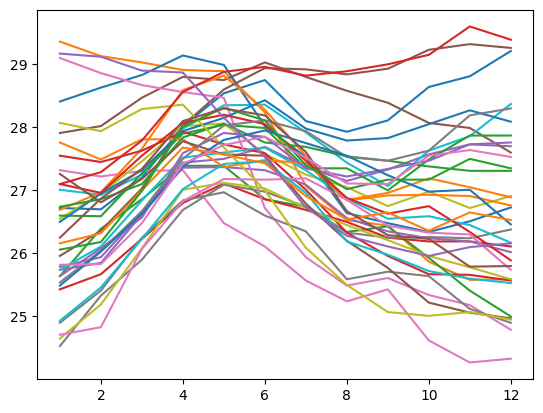

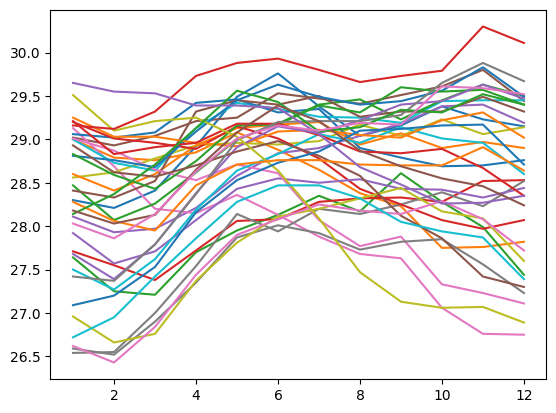

[ 1  2  3  4  5  6  7  8  9 10 11 12]


In [22]:
ElNino_OISST_region_3_y=ElNino_OISST_region_3['ElNino_OISST_region_3']['y'].to_numpy()
ElNino_OISST_region_3_x=ElNino_OISST_region_3['ElNino_OISST_region_3']['x']
plt.plot(ElNino_OISST_region_3_x,ElNino_OISST_region_3_y)
plt.show(

)
ElNino_OISST_region_3and4_y=ElNino_OISST_region_3and4['ElNino_OISST_region_3and4']['y'].to_numpy()
ElNino_OISST_region_3and4_x=ElNino_OISST_region_3and4['ElNino_OISST_region_3and4']['x']
plt.plot(ElNino_OISST_region_3and4_x,ElNino_OISST_region_3and4_y)
plt.show(
)


ElNino_OISST_region_4_y=ElNino_OISST_region_4['ElNino_OISST_region_4']['y'].to_numpy()
ElNino_OISST_region_4_x=ElNino_OISST_region_4['ElNino_OISST_region_4']['x']
plt.plot(ElNino_OISST_region_4_x,ElNino_OISST_region_4_y)
plt.show(
)
grid_points=ElNino_OISST_region_1and2_x
print(grid_points)

In [14]:
torch.tensor(ElNino_OISST_region_4['ElNino_OISST_region_4']['y'])

TypeError: len() of unsized object

In [10]:
fd=skfda.FDataGrid(ElNino_OISST_region_4['ElNino_OISST_region_4']['y'],grid_points=grid_points)
basis=skfda.representation.basis.BSplineBasis(knots=grid_points,order=4)
fd_basis=fd.to_basis(basis=basis)
fd_basis.plot()
plt.show()

SyntaxError: invalid syntax (3640109077.py, line 4)

In [142]:

#################################################
# FAE: one hidden layer
# Encoder: a added layer for fd representation
# Decoder:
#################################################

#####################################
# Define the vanilla FAE architecture
# Create FAE Class
#####################################
class FAE_vanilla(nn.Module):
    def __init__(self, weight_std=None):
        super(FAE_vanilla, self).__init__()
        self.fc1 = nn.Linear(n_basis, 50,bias=False)
        self.fc11 = nn.Linear(50, 25, bias=False)
        # self.fc12 = nn.Linear(25, 10, bias=False)
        self.fc2 = nn.Linear(25, n_rep, bias=False)
        # self.fc1 = nn.Linear(n_basis, n_rep, bias=False)
        self.fc3 = nn.Linear(n_rep, 37, bias=False)
        # self.fc3 = nn.Linear(n_rep, n_basis, bias=False)
        self.fc4 = nn.Linear(37, n_basis, bias=False)
        self.activation = nn.Sigmoid()

        # initialize the weights to a specified, constant value
        if (weight_std is not None):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.normal_(m.weight, mean=0.0, std=weight_std)
                    #nn.init.constant_(m.bias, 0)

    def forward(self, x, basis_fc):
        feature = self.Project(x, basis_fc.float().cuda())
        # rep = self.activation(self.fc1(feature))
        feature=torch.t(feature.float()).cuda()
        t1 = self.activation(self.fc1(feature))
        t1 = self.activation(self.fc11(t1))
        # t1 = self.activation(self.fc12(t1))
        rep = self.fc2(t1)
        t2 = self.activation(self.fc3(rep))
        coef = self.fc4(t2)
        # coef = self.fc3(rep)
        x_hat = self.Revert(coef, basis_fc)
        return x_hat, rep, feature, coef
    def Project(self, x, basis_fc):
        # basis_fc: n_time X nbasis
        # x: n_subject X n_time
        w = x.size(1)-1
        W = torch.tensor([1/(2*w)]+[1/w]*(w-1)+[1/(2*w)])
        f = torch.matmul(torch.t(basis_fc.float()),torch.mul(x, W.cuda()))
        return f
    def Revert(self, x, basis_fc):
        g = torch.matmul(basis_fc.float(),torch.t(x.float()))
        return g



In [16]:

def pred(model, data):
    model.eval()
    # input = data.type(torch.LongTensor)
    input = data.cuda()
    output, rep, feature, coef = model(input.float(), basis_fc)
    loss = loss_function(output, input.float())
    score_loss = loss_function(feature, coef)
    return output, rep, loss, score_loss

#####################################
# Load Data sets
#####################################
# Import dataset
# Dataset: tecator
# x_raw = pd.read_csv('Datasets/tecator/tecator.csv')
# tpts_raw = pd.read_csv('Datasets/tecator/tecator_tpts.csv')
# Dataset: pinch
# x_raw = pd.read_csv('Datasets/pinch/pinch.csv')
# tpts_raw = pd.read_csv('Datasets/pinch/pinch_tpts.csv')


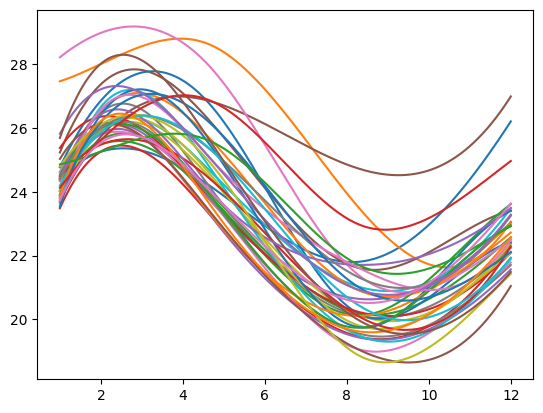

torch.Size([37, 6])

In [24]:
x=skfda.FDataGrid(ElNino_OISST_region_1and2_x)
FD_grid_region_1and_2=skfda.representation.FDataGrid(x0.detach().cpu(),grid_points=ElNino_OISST_region_1and2_x)
n_basis=6
n_rep=5
basis=skfda.representation.basis.BSplineBasis(knots=np.linspace(1,12,4),order=4)
basis_region_1and_2=FD_grid_region_1and_2.to_basis(basis)
basis_region_1and_2.plot()
basis_fc=torch.tensor(basis_region_1and_2.coefficients).float().cuda()
plt.show()
##Une fois les coefficients récupérés, on en fait une fonction de x puis 
##x vaudra une discrétisation du temps.
##On va zoomer la courbe pour faire de la convolution.
basis_fc.shape

In [25]:
x =torch.tensor(ElNino_OISST_region_1and2_y).cuda()
w = x0.size(1)-1
W = torch.tensor([1/(2*w)]+[1/w]*(w-1)+[1/(2*w)])
W


tensor([0.0455, 0.0909, 0.0909, 0.0909, 0.0909, 0.0909, 0.0909, 0.0909, 0.0909,
        0.0909, 0.0909, 0.0455])

In [26]:
grid_points=ElNino_OISST_region_1and2_x
[ElNino_OISST_region_1and2_y.shape,

print("grid_points=",grid_points)]
64*37

grid_points= [ 1  2  3  4  5  6  7  8  9 10 11 12]


2368

In [58]:
x0=torch.tensor(ElNino_OISST_region_1and2_y).float().cuda()
x1=torch.tensor(ElNino_OISST_region_3_y).float().cuda()
x2=torch.tensor(ElNino_OISST_region_4_y).float().cuda()
x3=torch.tensor(ElNino_OISST_region_3and4_y).float().cuda()
x0=torch.t(x0)
x1=torch.t(x1)
x2=torch.t(x2)
x3=torch.t(x3)

torch.Size([37, 6])


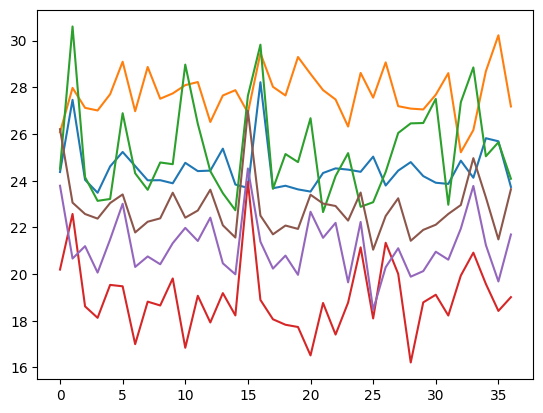

In [60]:

basis_fc=basis_region_1and_2.coefficients
basis_fc=torch.tensor(basis_fc).cuda()

plt.plot(basis_fc.cpu()[:,:])
print(basis_fc.shape)
plt.show()

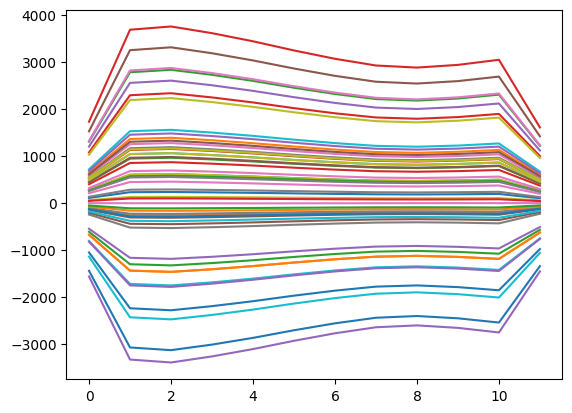

In [147]:

input=torch.matmul(torch.t(basis_fc.float()),torch.mul(x0,W.cuda()))

#FAE.fc1(torch.t(input).unsqueeze(0))


input=torch.t(input.float())
plt.plot(FAE.fc1(input)[:,:].detach().cpu())
plt.show()

In [159]:
FAE=FAE_vanilla(weight_std=0.3)
FAE=FAE.cuda()


torch.Size([37, 12]) torch.Size([12, 3]) torch.Size([12, 6]) torch.Size([12, 6])


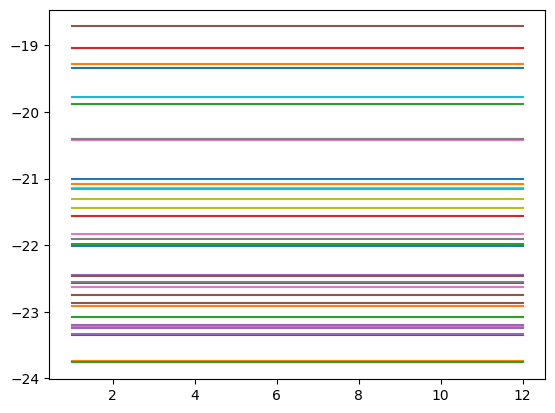

In [162]:
output,  rep,feature, coef =FAE(x0,basis_fc)
print(output.shape,  rep.shape,feature.shape, coef.shape)
FAE_output_DataGrid=skfda.FDataGrid(output[:,:].detach().cpu(),grid_points=grid_points)
FAE_output_DataGrid.plot()
plt.show()

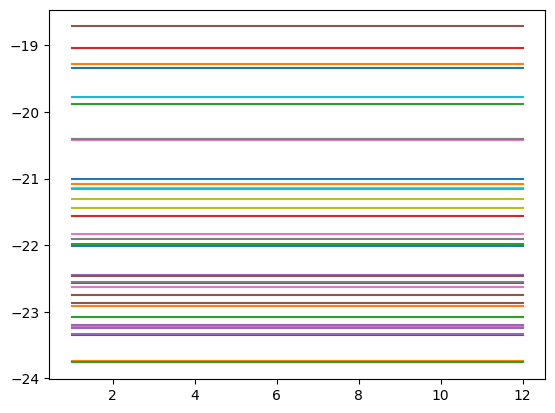

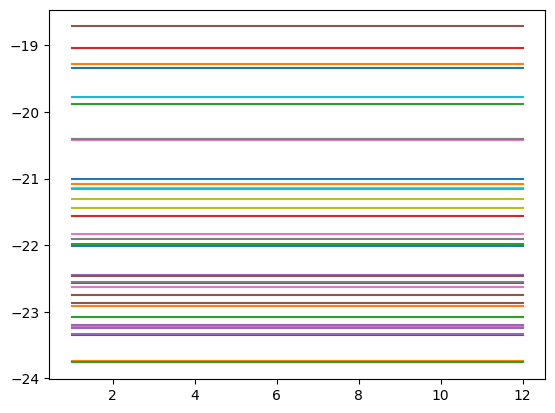

In [163]:
FAE_output_DataGrid.plot()
plt.show()
basis_revert=basis_region_1and_2
FAE_output_basis=FAE_output_DataGrid.to_basis(basis)
FAE_output_basis.plot()
plt.show()

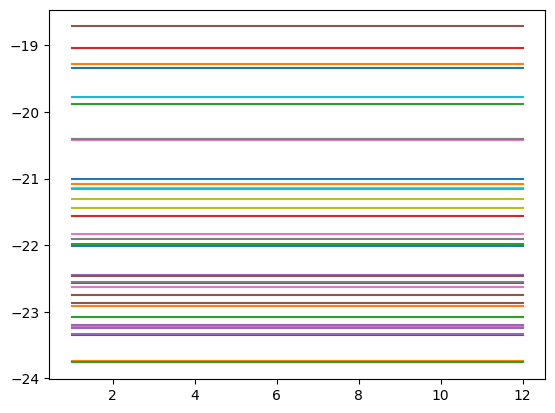

(37,)

In [164]:
FAE_output_basis.plot()
plt.show()
FAE_output_basis.shape

torch.Size([37, 12])

torch.Size([12, 6])


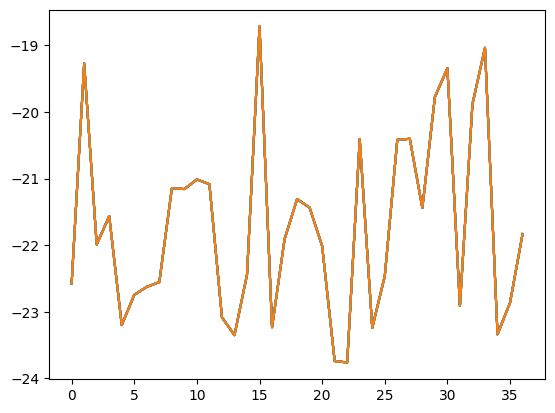

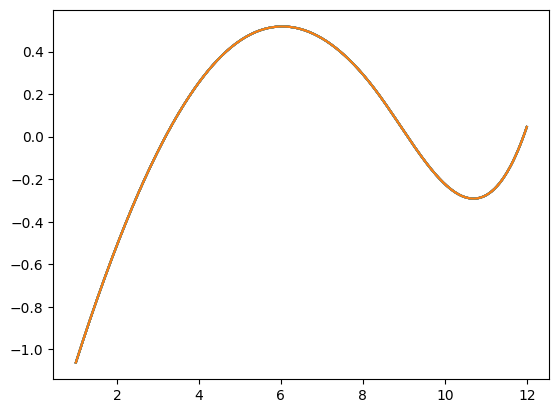

In [165]:

print(coef.shape)
plt.plot(output[:,:].detach().cpu())
plt.show()
output.shape



skfda.representation.FDataBasis(basis=basis,coefficients=coef.detach().cpu()).plot()
plt.show()

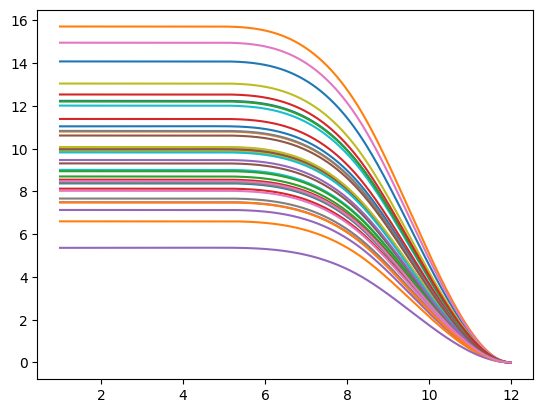

In [53]:
output_tobasis=skfda.FDataGrid(output.detach().cpu()).to_basis(basis)
output_tobasis.plot()
plt.show()

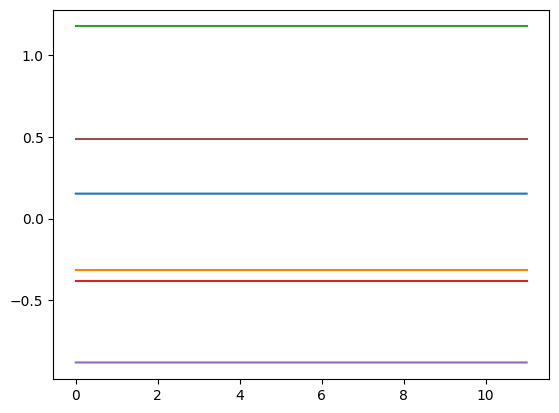

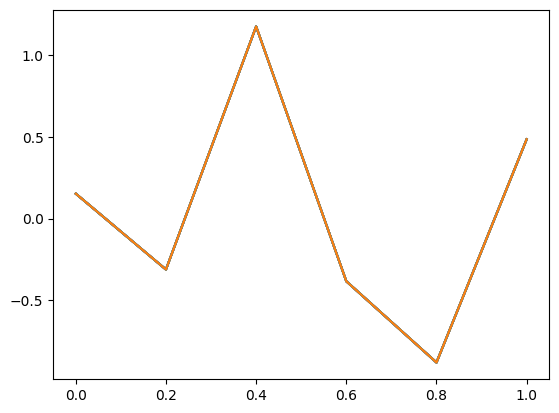

In [54]:
plt.plot(coef.detach().cpu())
plt.show()
coef_grid=skfda.representation.FDataGrid(coef.detach().cpu())
coef_grid.plot()
plt.show()

In [143]:
n_rep=3
FAE=FAE_vanilla(weight_std=0.3)
FAE=FAE.cuda()

In [144]:
lr=0.1
betas=[0.5,0.999]
batch_size=3

loss_function=nn.MSELoss()
optimizer=optim.Adam(FAE.parameters(),lr=lr,betas=betas)
indice=np.arange(37)
train_loader=torch.utils.data.DataLoader(x0,batch_size)
#print("Loader entier=",train_loader.dataset.shape)
#for i,b in enumerate(train_loader):
#    print ("Itération du",i,"ème batch=",b.shape)

In [123]:

from tqdm import tqdm
def train(n_epochs,x):
    train_loss=torch.tensor(0).cuda()
    for i,functions in enumerate(train_loader):
        basis_fc_train=torch.tensor(skfda.FDataGrid(data_matrix=functions.detach().cpu(),grid_points=grid_points).to_basis(basis).coefficients).float().cuda()
        functions_train=functions.float().cuda()
        optimizer.zero_grad()
        output,rep,feature,coef=FAE(functions_train,basis_fc_train)
        print(i,basis_fc_train.shape,coef.shape)
        loss=loss_function(basis_fc_train.float(),coef.float())
        
        loss.backward()
        optimizer.step()
        train_loss+=loss.long()
    return train_loss,loss 

        


        


In [145]:
region_de_test=x0
train(1000,x=region_de_test)




0 torch.Size([3, 6]) torch.Size([12, 6])


c:\Users\Utilisateur\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([12, 6])) that is different to the input size (torch.Size([3, 6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (3) must match the size of tensor b (12) at non-singleton dimension 0

In [141]:
out_project=FAE.Project(x=x0.float(),basis_fc=basis_fc)
out_project.shape

torch.Size([6, 12])

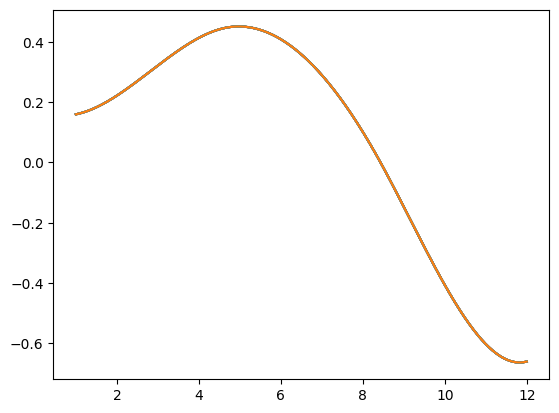

FDataBasis(
    basis=BSplineBasis(domain_range=((1.0, 12.0),), n_basis=6, order=4, knots=(1.0, 4.666666666666666, 8.333333333333332, 12.0)),
    coefficients=[[ 0.15966973  0.19365868  0.6376753   0.16095915 -0.70498455 -0.66058344]
     [ 0.15966973  0.19365865  0.6376753   0.16095918 -0.70498455 -0.6605834 ]
     [ 0.15966973  0.19365865  0.6376753   0.16095918 -0.70498455 -0.6605834 ]
     [ 0.15966973  0.19365865  0.6376753   0.16095918 -0.70498455 -0.6605834 ]
     [ 0.15966973  0.19365865  0.6376753   0.16095918 -0.70498455 -0.6605834 ]
     [ 0.15966973  0.19365865  0.6376753   0.16095918 -0.70498455 -0.6605834 ]
     [ 0.15966973  0.19365865  0.6376753   0.16095918 -0.70498455 -0.6605834 ]
     [ 0.15966973  0.19365865  0.6376753   0.16095918 -0.70498455 -0.6605834 ]
     [ 0.15966973  0.19365865  0.6376753   0.16095918 -0.70498455 -0.6605834 ]
     [ 0.15966973  0.19365865  0.6376753   0.16095918 -0.70498455 -0.6605834 ]
     [ 0.15966973  0.19365865  0.6376753   0.16095918 -

In [132]:
output,rep,feature,coef=FAE(x =x0.float(),basis_fc=basis_fc.float())
skfda.FDataBasis(basis=basis, coefficients=coef.detach().cpu()).plot()
plt.show()
skfda.FDataBasis(basis=basis, coefficients=coef.detach().cpu())

torch.Size([37, 12])


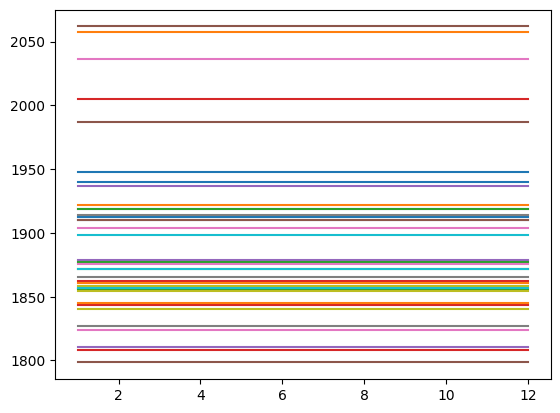

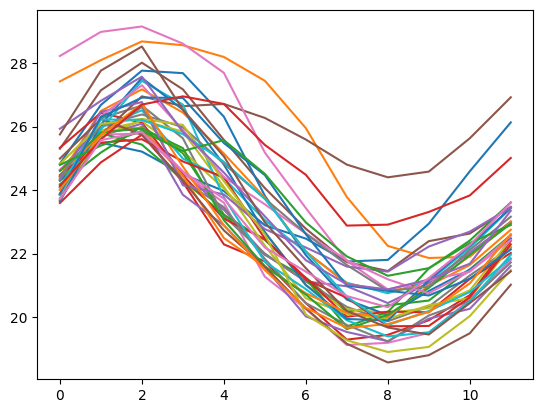

torch.Tensor

In [110]:
output,rep,feature,coef=FAE(x =x0.float(),basis_fc=basis_fc.float())
print(output.shape)
skfda.FDataGrid(output[:,:].detach().cpu(),grid_points=grid_points).plot()
plt.show()
plt.plot(x.detach().cpu())
plt.show()
type(x)

In [87]:
output.shape
x0.shape

torch.Size([37, 12])

In [44]:

def pred(model, data):
    
    # input = data.type(torch.LongTensor)
    input = data.cuda()
    output, rep, feature, coef = model(input.float(), basis_fc.float())
    loss = loss_function(output.float(), input.float())
    score_loss = loss_function(feature.float(), coef.float())
    return output, rep, loss, score_loss

#####################################
# Load Data sets
#####################################
# Import dataset
# Dataset: tecator
# x_raw = pd.read_csv('Datasets/tecator/tecator.csv')
# tpts_raw = pd.read_csv('Datasets/tecator/tecator_tpts.csv')
# Dataset: pinch
# x_raw = pd.read_csv('Datasets/pinch/pinch.csv')
# tpts_raw = pd.read_csv('Datasets/pinch/pinch_tpts.csv')


In [167]:
output, rep, loss, score_loss= pred(FAE,x)

print([output.shape, rep.shape, loss, score_loss])

RuntimeError: mat1 and mat2 shapes cannot be multiplied (6x37 and 12x37)

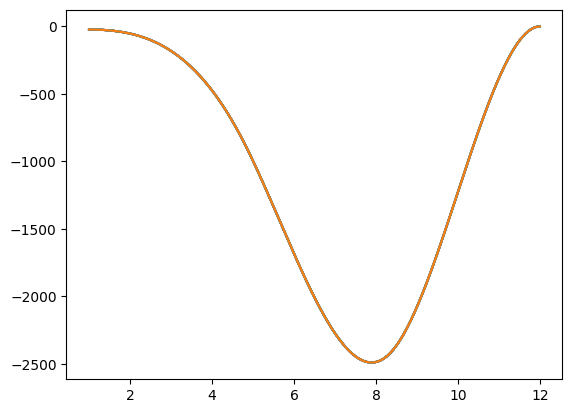

In [168]:
output_tobasis=skfda.FDataGrid(torch.t(output[:,:]).detach().cpu()).to_basis(basis)
output_tobasis.plot()
plt.show()


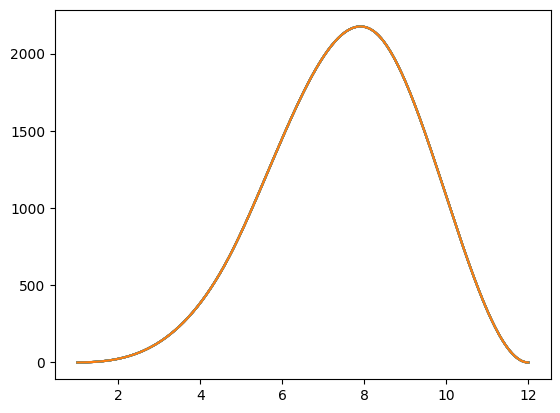

In [169]:
coef_basis_smoothed=skfda.FDataGrid(coef.detach().cpu()).to_basis(basis)
coef_basis_smoothed.plot()
plt.show()

In [170]:
import gc
import torch
torch.cuda.empty_cache()
gc.collect()

88254

In [420]:

# Set up NN hyperparameters:
epochs = 25
batch_size = 32


# Start iterations
for i in range(niter):
    # Split training/test set
    TrainData, TestData, TrainLabel, TestLabel, train_no =train_test_split(x, label, split_rate =0.8, seed_no=niter_seed[i])
    FAE_train_no_niter.append(train_no)
    # Define data loaders; DataLoader is used to load the dataset for training
    train_loader = torch.utils.data.DataLoader(TrainData, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(TestData)

    # Model Initialization
    model = FAE_vanilla(weight_std=1)
    model=model.cuda()
    # Validation using MSE Loss function
    loss_function = nn.MSELoss()
    # Using an Adam Optimizer
    optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
    # Set to CPU/GPU
    device = torch.device("cuda:0")  # (?)should be CUDA when running on the big powerfull server

    epochs = epochs
    # losses = []
    # score_losses = []

    # Train model
    for epoch in range(1, epochs + 1):
        loss, score_loss = train(train_loader=train_loader, pen=pen, lamb=lamb)
        # losses.append(loss.detach().numpy())
        # score_losses.append(score_loss.detach().numpy())
        #if epoch == epochs:
        FAE_pred_test, FAE_reps_test, FAE_pred_loss_test, FAE_pred_score_loss_test = pred(model, TestData)
        if epoch % 100 == 0:
            print(f"Epoch[{epoch}]-loss: {loss:.4f}; feature loss: {score_loss: 4f}; pred_loss:{FAE_pred_loss_test:4f}")

    # Debug by looking at loss
    # plt.plot(losses, label = "train_loss")
    # plt.legend()
   

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
 # plt.show()
    # plt.close()

    # Debug by looking at the FAE, layer by layer
    # s = model.Project(input,basis_fc)
    # rep = model.activation(model.fc1(s))
    # s_hat = model.activation(model.fc3(rep))
    # output = model.Revert(s_hat,basis_fc)

    FAE_reps_test_niter.append(FAE_reps_test)
    FAE_pred_test_niter.append(FAE_pred_test)
    FAE_pred_all, FAE_reps_all = pred(model, x)[0:2]
    FAE_reps_all_niter.append(FAE_reps_all)
    FAE_pred_all_niter.append(FAE_pred_all)

    # FAE_pred_test_acc_mean_niter.append(eval_mse_sdse(TestData, FAE_pred_test)[0].tolist())
    FAE_pred_test_acc_mean_niter.append(FAE_pred_loss_test.tolist())
    FAE_pred_test_acc_sd_niter.append(eval_mse_sdse(TestData, FAE_pred_test)[1].tolist())

    FAE_pred_train, FAE_reps_train, FAE_pred_loss_train, FAE_pred_score_loss_train = pred(model, TrainData)
    FAE_reps_train_niter.append(FAE_reps_train)
    FAE_pred_train_acc_mean_niter.append(FAE_pred_loss_train.tolist())
    FAE_pred_train_acc_sd_niter.append(eval_mse_sdse(TrainData, FAE_pred_train)[1].tolist())

    ## Classification
    # Create classifiers (logistic regression) & train the model with the training set
    FAE_classifier = LogisticRegression(solver='liblinear', random_state=0, multi_class='auto').fit(FAE_reps_train.detach().numpy(), TrainLabel)
    # Evaluate the classifier with the test set
    # FAE_classifier.predict(FAE_reps_test)
    # Classification accuracy on the test set
    classification_FAE_test_niter.append(FAE_classifier.score(FAE_reps_test.detach().numpy(), TestLabel))
    # Classification accuracy on the training set
    classification_FAE_train_niter.append(FAE_classifier.score(FAE_reps_train.detach().numpy(), TrainLabel))

    ## Clustering
    optimal_n_cluster = len(np.unique(label)) #len(set(label))
    kmeans_par = {"init": "random", "n_init": 10, "max_iter": 300, "random_state": 0}
    kmeans_labels_FAE = KMeans(n_clusters=optimal_n_cluster, **kmeans_par).fit_predict(FAE_reps_all.detach().numpy())
    # for i in range(optimal_n_cluster):
    #     no_FAE = np.count_nonzero(kmeans_labels_FAE == i)
    acc_list_FAE = []
    label_list_FAE = []
    for j in range(optimal_n_cluster):
        ind = indices(label, lambda x: x==np.unique(label)[j])
        acc_list_FAE.append(acc(kmeans_labels_FAE[ind], optimal_n_cluster))
        label_list_FAE.append(most_frequent(kmeans_labels_FAE[ind], optimal_n_cluster))
    clustering_FAE_acc_niter.append(acc_list_FAE)
    clustering_FAE_acc_mean_niter.append(mean(acc_list_FAE))
    clustering_FAE_acc_sd_niter.append(std(acc_list_FAE))

# Print for result tables
print("--- FAE-Nonlinear Results --- \n"
      f"Train Pred Acc Mean: {mean(FAE_pred_train_acc_mean_niter):.4f}; "
      f"Train Pred Acc SD: {std(FAE_pred_train_acc_mean_niter):.4f}; \n"
      f"Test Pred Acc Mean: {mean(FAE_pred_test_acc_mean_niter):.4f}; "
      f"Test Pred Acc SD: {std(FAE_pred_test_acc_mean_niter):.4f}; \n"
      f"Train Classification Acc Mean: {mean(classification_FAE_train_niter):.4f}; "
      f"Train Classification Acc SD: {std(classification_FAE_train_niter):.4f}; \n"
      f"Test Classification Acc Mean: {mean(classification_FAE_test_niter):.4f}; "
      f"Test Classification Acc SD: {std(classification_FAE_test_niter):.4f}; \n"
      f"Clustering Acc Mean (by clusters): {np.around(mean(clustering_FAE_acc_niter, axis=0), 4)};\n" 
      #[round(i, 4) for i in mean(clustering_FAE_acc_niter, axis=0)] or [f"{num:.4f}" for num in mean(clustering_FAE_acc_niter, axis=0)]
      f"Overall Clustering Acc Mean: {mean(clustering_FAE_acc_mean_niter):.4f};")

stats.ttest_rel(classification_FAE_test_niter, classification_FPCA_test_niter)
stats.ttest_rel(classification_FAE_test_niter, classification_AE_test_niter)

# If activation function is nn.Identity()
FAE_identity_train_no_niter = FAE_train_no_niter.copy()
FAE_identity_reps_train_niter = FAE_reps_train_niter.copy()
FAE_identity_reps_test_niter = FAE_reps_test_niter.copy()
FAE_identity_reps_all_niter = FAE_reps_all_niter.copy()
FAE_identity_pred_test_niter = FAE_pred_test_niter.copy()
FAE_identity_pred_all_niter = FAE_pred_all_niter.copy()
FAE_identity_pred_train_acc_mean_niter = FAE_pred_train_acc_mean_niter.copy()
FAE_identity_pred_test_acc_mean_niter = FAE_pred_test_acc_mean_niter.copy()
FAE_identity_pred_train_acc_sd_niter = FAE_pred_train_acc_sd_niter.copy()
FAE_identity_pred_test_acc_sd_niter = FAE_pred_test_acc_sd_niter.copy()
classification_FAE_identity_train_niter = classification_FAE_train_niter.copy()
classification_FAE_identity_test_niter = classification_FAE_test_niter.copy()
clustering_FAE_identity_acc_niter = clustering_FAE_acc_niter.copy()
clustering_FAE_identity_acc_mean_niter = clustering_FAE_acc_mean_niter.copy()
clustering_FAE_identity_acc_sd_niter = clustering_FAE_acc_sd_niter.copy()


In [ ]:

# Print for result tables
print("--- FAE-Nonlinear Results --- \n"
      f"Train Pred Acc Mean: {mean(FAE_pred_train_acc_mean_niter):.4f}; "
      f"Train Pred Acc SD: {std(FAE_pred_train_acc_mean_niter):.4f}; \n"
      f"Test Pred Acc Mean: {mean(FAE_pred_test_acc_mean_niter):.4f}; "
      f"Test Pred Acc SD: {std(FAE_pred_test_acc_mean_niter):.4f}; \n"
      f"Train Classification Acc Mean: {mean(classification_FAE_train_niter):.4f}; "
      f"Train Classification Acc SD: {std(classification_FAE_train_niter):.4f}; \n"
      f"Test Classification Acc Mean: {mean(classification_FAE_test_niter):.4f}; "
      f"Test Classification Acc SD: {std(classification_FAE_test_niter):.4f}; \n"
      f"Clustering Acc Mean (by clusters): {np.around(mean(clustering_FAE_acc_niter, axis=0), 4)};\n" 
      #[round(i, 4) for i in mean(clustering_FAE_acc_niter, axis=0)] or [f"{num:.4f}" for num in mean(clustering_FAE_acc_niter, axis=0)]
      f"Overall Clustering Acc Mean: {mean(clustering_FAE_acc_mean_niter):.4f};")

stats.ttest_rel(classification_FAE_test_niter, classification_FPCA_test_niter)
stats.ttest_rel(classification_FAE_test_niter, classification_AE_test_niter)

# If activation function is nn.Identity()
FAE_identity_train_no_niter = FAE_train_no_niter.copy()
FAE_identity_reps_train_niter = FAE_reps_train_niter.copy()
FAE_identity_reps_test_niter = FAE_reps_test_niter.copy()
FAE_identity_reps_all_niter = FAE_reps_all_niter.copy()
FAE_identity_pred_test_niter = FAE_pred_test_niter.copy()
FAE_identity_pred_all_niter = FAE_pred_all_niter.copy()
FAE_identity_pred_train_acc_mean_niter = FAE_pred_train_acc_mean_niter.copy()
FAE_identity_pred_test_acc_mean_niter = FAE_pred_test_acc_mean_niter.copy()
FAE_identity_pred_train_acc_sd_niter = FAE_pred_train_acc_sd_niter.copy()
FAE_identity_pred_test_acc_sd_niter = FAE_pred_test_acc_sd_niter.copy()
classification_FAE_identity_train_niter = classification_FAE_train_niter.copy()
classification_FAE_identity_test_niter = classification_FAE_test_niter.copy()
clustering_FAE_identity_acc_niter = clustering_FAE_acc_niter.copy()
clustering_FAE_identity_acc_mean_niter = clustering_FAE_acc_mean_niter.copy()
clustering_FAE_identity_acc_sd_niter = clustering_FAE_acc_sd_niter.copy()


In [ ]:

    FAE_reps_test_niter.append(FAE_reps_test)
    FAE_pred_test_niter.append(FAE_pred_test)
    FAE_pred_all, FAE_reps_all = pred(model, x)[0:2]
    FAE_reps_all_niter.append(FAE_reps_all)
    FAE_pred_all_niter.append(FAE_pred_all)

    # FAE_pred_test_acc_mean_niter.append(eval_mse_sdse(TestData, FAE_pred_test)[0].tolist())
    FAE_pred_test_acc_mean_niter.append(FAE_pred_loss_test.tolist())
    FAE_pred_test_acc_sd_niter.append(eval_mse_sdse(TestData, FAE_pred_test)[1].tolist())

    FAE_pred_train, FAE_reps_train, FAE_pred_loss_train, FAE_pred_score_loss_train = pred(model, TrainData)
    FAE_reps_train_niter.append(FAE_reps_train)
    FAE_pred_train_acc_mean_niter.append(FAE_pred_loss_train.tolist())
    FAE_pred_train_acc_sd_niter.append(eval_mse_sdse(TrainData, FAE_pred_train)[1].tolist())

    ## Classification
    # Create classifiers (logistic regression) & train the model with the training set
    FAE_classifier = LogisticRegression(solver='liblinear', random_state=0, multi_class='auto').fit(FAE_reps_train.detach().numpy(), TrainLabel)
    # Evaluate the classifier with the test set
    # FAE_classifier.predict(FAE_reps_test)
    # Classification accuracy on the test set
    classification_FAE_test_niter.append(FAE_classifier.score(FAE_reps_test.detach().numpy(), TestLabel))
    # Classification accuracy on the training set
    classification_FAE_train_niter.append(FAE_classifier.score(FAE_reps_train.detach().numpy(), TrainLabel))

    ## Clustering
    optimal_n_cluster = len(np.unique(label)) #len(set(label))
    kmeans_par = {"init": "random", "n_init": 10, "max_iter": 300, "random_state": 0}
    kmeans_labels_FAE = KMeans(n_clusters=optimal_n_cluster, **kmeans_par).fit_predict(FAE_reps_all.detach().numpy())
    # for i in range(optimal_n_cluster):
    #     no_FAE = np.count_nonzero(kmeans_labels_FAE == i)
    acc_list_FAE = []
    label_list_FAE = []
    for j in range(optimal_n_cluster):
        ind = indices(label, lambda x: x==np.unique(label)[j])
        acc_list_FAE.append(acc(kmeans_labels_FAE[ind], optimal_n_cluster))
        label_list_FAE.append(most_frequent(kmeans_labels_FAE[ind], optimal_n_cluster))
    clustering_FAE_acc_niter.append(acc_list_FAE)
    clustering_FAE_acc_mean_niter.append(mean(acc_list_FAE))
    clustering_FAE_acc_sd_niter.append(std(acc_list_FAE))

# Print for result tables
print("--- FAE-Nonlinear Results --- \n"
      f"Train Pred Acc Mean: {mean(FAE_pred_train_acc_mean_niter):.4f}; "
      f"Train Pred Acc SD: {std(FAE_pred_train_acc_mean_niter):.4f}; \n"
      f"Test Pred Acc Mean: {mean(FAE_pred_test_acc_mean_niter):.4f}; "
      f"Test Pred Acc SD: {std(FAE_pred_test_acc_mean_niter):.4f}; \n"
      f"Train Classification Acc Mean: {mean(classification_FAE_train_niter):.4f}; "
      f"Train Classification Acc SD: {std(classification_FAE_train_niter):.4f}; \n"
      f"Test Classification Acc Mean: {mean(classification_FAE_test_niter):.4f}; "
      f"Test Classification Acc SD: {std(classification_FAE_test_niter):.4f}; \n"
      f"Clustering Acc Mean (by clusters): {np.around(mean(clustering_FAE_acc_niter, axis=0), 4)};\n" 
      #[round(i, 4) for i in mean(clustering_FAE_acc_niter, axis=0)] or [f"{num:.4f}" for num in mean(clustering_FAE_acc_niter, axis=0)]
      f"Overall Clustering Acc Mean: {mean(clustering_FAE_acc_mean_niter):.4f};")

stats.ttest_rel(classification_FAE_test_niter, classification_FPCA_test_niter)
stats.ttest_rel(classification_FAE_test_niter, classification_AE_test_niter)

# If activation function is nn.Identity()
FAE_identity_train_no_niter = FAE_train_no_niter.copy()
FAE_identity_reps_train_niter = FAE_reps_train_niter.copy()
FAE_identity_reps_test_niter = FAE_reps_test_niter.copy()
FAE_identity_reps_all_niter = FAE_reps_all_niter.copy()
FAE_identity_pred_test_niter = FAE_pred_test_niter.copy()
FAE_identity_pred_all_niter = FAE_pred_all_niter.copy()
FAE_identity_pred_train_acc_mean_niter = FAE_pred_train_acc_mean_niter.copy()
FAE_identity_pred_test_acc_mean_niter = FAE_pred_test_acc_mean_niter.copy()
FAE_identity_pred_train_acc_sd_niter = FAE_pred_train_acc_sd_niter.copy()
FAE_identity_pred_test_acc_sd_niter = FAE_pred_test_acc_sd_niter.copy()
classification_FAE_identity_train_niter = classification_FAE_train_niter.copy()
classification_FAE_identity_test_niter = classification_FAE_test_niter.copy()
clustering_FAE_identity_acc_niter = clustering_FAE_acc_niter.copy()
clustering_FAE_identity_acc_mean_niter = clustering_FAE_acc_mean_niter.copy()
clustering_FAE_identity_acc_sd_niter = clustering_FAE_acc_sd_niter.copy()


In [ ]:

# Print for result tables
print("--- FAE-Indentity Results --- \n"
      f"Train Pred Acc Mean: {mean(FAE_identity_pred_train_acc_mean_niter):.4f}; "
      f"Train Pred Acc SD: {std(FAE_identity_pred_train_acc_mean_niter):.4f}; \n"
      f"Test Pred Acc Mean: {mean(FAE_identity_pred_test_acc_mean_niter):.4f}; "
      f"Test Pred Acc SD: {std(FAE_identity_pred_test_acc_mean_niter):.4f}; \n"
      f"Train Classification Acc Mean: {mean(classification_FAE_identity_train_niter):.4f}; "
      f"Train Classification Acc SD: {std(classification_FAE_identity_train_niter):.4f}; \n"
      f"Test Classification Acc Mean: {mean(classification_FAE_identity_test_niter):.4f}; "
      f"Test Classification Acc SD: {std(classification_FAE_identity_test_niter):.4f}; \n"
      f"Clustering Acc Mean (by clusters): {np.around(mean(clustering_FAE_identity_acc_niter, axis=0), 4)};\n" 
      f"Overall Clustering Acc Mean: {mean(clustering_FAE_identity_acc_mean_niter):.4f};")



In [ ]:

# Plot of Input (Observed Curves) & Output Curves (Predicted Curves)
i=1
TestData = x[[j for j in range(len(x)) if j not in FAE_train_no_niter[i]]]
input_plt = TestData.detach().numpy()
FAE_pred_plt = FAE_pred_test_niter[i].detach().numpy()

plt.figure(2, figsize=(10, 20))
plt.subplot(211)
for m in range(0, len(input_plt)):
# for m in id_plt:
    plt.plot(tpts, input_plt[m])
plt.title("Raw Curves")
plt.subplot(212)
for m in range(0, len(FAE_pred_plt)):
# for m in id_plt:
    plt.plot(tpts, FAE_pred_plt[m])
plt.title("FAE-predicted Curves")
plt.show()

# Perform paired t-test
stats.ttest_rel(FAE_identity_pred_test_acc_mean_niter, FPCA_pred_test_acc_mean_niter)
stats.ttest_rel(classification_FAE_identity_test_niter, classification_FPCA_test_niter)
stats.ttest_rel(clustering_FAE_identity_acc_mean_niter, clustering_FPCA_acc_mean_niter)é